In [30]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc


In [122]:

class MultiModalDataset(Dataset):
    def __init__(self, audio_dir, visual_dir, split_file, annotation_file):
        self.audio_dir = audio_dir
        self.visual_dir = visual_dir

        # Load file IDs from split file
        with open(split_file, 'r') as f:
            fids = f.read().splitlines()

        # Generate paths to audio and visual files
        self.audio_files = [os.path.join(audio_dir, f"{i}.npy") for i in fids]
        self.visual_files = [os.path.join(visual_dir, f"{i}.npy") for i in fids]

        # Generate labels from file IDs
        self.labels = [1 if 'lie' in fid.lower() else 0 for fid in fids]

        # Load annotations
        self.annotations = pd.read_csv(annotation_file, index_col=0)
        missing_fids = [fid.split('/')[-1] for fid in fids if fid not in self.annotations.index]
        if missing_fids:
            raise ValueError(f"Missing file ids in annotation file: {missing_fids}")
        self.annotations = self.annotations.loc[fids].values

        # Ensure that files exist
        for i in self.audio_files:
            if not os.path.exists(i):
                raise FileNotFoundError(f"File not found: {i}")
        for i in self.visual_files:
            if not os.path.exists(i):
                raise FileNotFoundError(f"File not found: {i}")
    
    def __getitem__(self, idx):
        # Load audio and visual features
        audio_features = np.load(self.audio_files[idx])
        visual_features = np.load(self.visual_files[idx])
        
        # Ensure the same length for both modalities
        min_length = min(audio_features.shape[0], visual_features.shape[0])
        audio_features = audio_features[:min_length]
        visual_features = visual_features[:min_length]

        # Get annotations for this sample
        annotation = self.annotations[idx]
        annotation_repeated = np.tile(annotation, (min_length, 1))

        # Concatenate audio, visual features, and annotations
        concat_data = np.concatenate((audio_features, visual_features, annotation_repeated), axis=1)
        
        # Convert to tensor
        concat_data = torch.tensor(concat_data, dtype=torch.float32)
        
        # Get the label for this sample
        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.long)

        return concat_data, label
    
    def __len__(self):
        return len(self.audio_files)

def collate_fn(batch):
    data, labels = zip(*batch)
    
    # Determine the max length of the sequences
    max_len = max([i.shape[0] for i in data])
    
    # Pad sequences to the max length
    padded_batch = [torch.nn.functional.pad(i, (0, 0, 0, max_len - i.shape[0])) for i in data]
    
    # Stack into a tensor
    data = torch.stack(padded_batch)
    
    # Stack labels into a tensor
    labels = torch.tensor(labels)
    
    return data, labels

# Example usage
audio_dir = "/data/lie_detection/clips_umich/opensmile_extraction"
visual_dir = "/data/lie_detection/clips_umich/viT_50hz"
split_file = "/data/lie_detection/clips_umich/train.txt"
annotation_file = "/home/blastaistudent/proj-lie-detection/annotation_id_as_index.csv"

dataset = MultiModalDataset(audio_dir, visual_dir, split_file, annotation_file)
print(f"dataset sample shape: {dataset[0][0].shape}, label: {dataset[0][1]}")

dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=collate_fn)

batch = next(iter(dataloader))
print(batch[0].shape, batch[1].shape)


dataset sample shape: torch.Size([1, 6885]), label: 1
torch.Size([8, 1, 6885]) torch.Size([8])


In [123]:
batch_size=12
val_split="/data/lie_detection/clips_umich/val.txt"
valset = MultiModalDataset(audio_dir, visual_dir, val_split,annotation_file)
valloader = DataLoader(valset, batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [124]:

test_split = "/data/lie_detection/clips_umich/test.txt"
testset = MultiModalDataset(audio_dir, visual_dir, test_split, annotation_file)
testloader = DataLoader(testset, batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [125]:

# Define compute_roc_auc function
def compute_roc_auc(indices, clf, X, y):
    y_true = []

    for i in indices:
        y_true.append(y[i])
    y_pred = clf.predict_proba(X[indices])[:, 1]  # assuming binary classification
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc


# Define plot_roc_curve function
def plot_roc_curve(fprs, tprs):
    plt.figure()
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        plt.plot(fpr, tpr, lw=2, label=f'Fold {i+1} (AUC = {auc(fpr, tpr):.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# augmentation

In [126]:


# Define a function for data augmentation
def augment_data(features, labels, num_augmented_samples):
    augmented_features = []
    augmented_labels = []
    
    for i in range(len(features)):
        for _ in range(num_augmented_samples):
            noise = np.random.normal(0, 0.01, features[i].shape)
            augmented_features.append(features[i] + noise)
            augmented_labels.append(labels[i])
            
    augmented_features = np.array(augmented_features)   
    augmented_labels = np.array(augmented_labels)
    
    # Combine original and augmented data
    combined_augmented_features = np.vstack((features, augmented_features))
    combined_augmented_labels = np.hstack((labels, augmented_labels))
    
    return combined_augmented_features, combined_augmented_labels




# split

In [127]:

# Assuming 'data_loader' is your DataLoader object
X = []
y = dataloader.dataset.labels + testloader.dataset.labels 




# Iterate through the DataLoader to extract features and labels
for i in range(len(dataloader.dataset)):
    X.append(dataloader.dataset[i][0][0])

# Concatenate all the features and labels into single tensors
for i in range(len(testloader.dataset)):
    X.append(testloader.dataset[i][0][0])
"""
for i in range(len(valloader.dataset)):
    X.append(valloader.dataset[i][0][0])

"""
print("Features shape:", X)
print("Labels shape:", y)

X = np.array(X)


Features shape: [tensor([ 2.5671,  0.3718,  0.0000,  ...,  0.0892,  0.2583, -0.0228]), tensor([ 0.8043,  0.1046,  0.6522,  ...,  0.2905,  0.5073, -0.2625]), tensor([ 0.6784,  0.0706,  0.0083,  ...,  0.3782,  0.2573, -0.5127]), tensor([ 0.9765,  0.3418,  0.3026,  ...,  0.3984,  0.3872, -0.1648]), tensor([ 0.1562,  0.8453,  0.3731,  ...,  0.6665,  0.5620, -0.0122]), tensor([ 1.0348,  0.1223,  0.2029,  ...,  0.4373,  0.4800, -0.1054]), tensor([ 0.9095,  0.2808,  0.9437,  ..., -0.0273,  0.5723,  0.1252]), tensor([ 1.1525,  0.2213,  0.8617,  ...,  0.4163,  0.3572, -0.0388]), tensor([2.2861, 0.7956, 0.3503,  ..., 0.2194, 0.1797, 0.1163]), tensor([ 1.3397,  0.3178,  0.2346,  ...,  0.5112,  0.3669, -0.2181]), tensor([0.5668, 0.2763, 0.0000,  ..., 0.2607, 0.1525, 0.4617]), tensor([ 2.3730,  0.7413,  0.0443,  ...,  0.4309, -0.0393, -0.1610]), tensor([ 0.8675,  0.1452,  0.7814,  ...,  0.4546,  0.3335, -0.2251]), tensor([ 1.6597,  0.4028,  0.1373,  ...,  0.5225,  0.4478, -0.2920]), tensor([ 0.9847

In [86]:
len(X)

108

In [87]:
len(y)

108

In [128]:
X_test =[]
y_test = testloader.dataset.labels


for i in range(len(testloader.dataset)):
    X_test.append(testloader.dataset[i][0][0])

print("Features shape:", X_test)
print("Labels shape:", y_test)
X_test = np.array(X_test)



Features shape: [tensor([1.7519, 0.1595, 0.0000,  ..., 0.2257, 0.2786, 0.5649]), tensor([ 0.5805,  0.2046,  0.1383,  ...,  0.7188,  0.1120, -0.1973]), tensor([ 2.7391,  0.9708,  0.3145,  ...,  0.7368,  0.1232, -0.2205]), tensor([ 1.0791,  0.4813,  0.0000,  ...,  0.3782,  0.2080, -0.2374]), tensor([ 2.7932,  0.8819,  0.0000,  ...,  0.4373,  0.3040, -0.1908]), tensor([ 0.7295,  0.4567,  0.5161,  ...,  0.0383,  0.4304, -0.1137]), tensor([ 0.9499,  0.5943,  0.1400,  ...,  0.1567,  0.1606, -0.3340]), tensor([1.5177, 0.0253, 0.0000,  ..., 0.2668, 0.1399, 0.7485]), tensor([ 5.7382,  0.5324,  0.0000,  ...,  1.0488,  0.2932, -0.0945]), tensor([ 1.2899,  0.9987,  0.0644,  ...,  0.3823, -0.0392,  0.4028]), tensor([ 0.7548,  0.6169,  0.4785,  ...,  0.5322,  0.3574, -0.0873]), tensor([0.6931, 0.5981, 0.0397,  ..., 0.8477, 0.0967, 0.2345]), tensor([0.8643, 0.6061, 0.0481,  ..., 0.4326, 0.0470, 0.2184]), tensor([ 1.1530,  0.6936,  0.8015,  ...,  0.5923,  0.2944, -0.1484]), tensor([1.6060, 0.6392, 0.0

In [129]:
X_val =[]
y_val = valloader.dataset.labels


for i in range(len(valloader.dataset)):
    X_val.append(valloader.dataset[i][0][0])

print("Features shape:", X_val)
print("Labels shape:", y_val)
X_val = np.array(X_val)



Features shape: [tensor([ 0.9334,  0.9580,  0.5324,  ...,  0.4080,  0.4783, -0.1572]), tensor([ 0.9922,  0.6797,  0.0246,  ...,  0.4736,  0.4460, -0.2455]), tensor([ 0.6261,  0.8040,  0.5378,  ...,  0.2498,  0.3091, -0.1877]), tensor([1.6840, 0.5448, 0.6566,  ..., 0.9590, 0.0731, 0.0054]), tensor([1.1306, 0.0107, 0.0000,  ..., 0.6689, 0.3196, 0.5518]), tensor([ 3.6417,  0.6650,  0.0000,  ...,  0.3713,  0.1080, -0.1803]), tensor([ 1.3384,  0.6053,  0.5947,  ...,  0.8306,  0.6729, -0.0137]), tensor([ 0.5014,  0.8462,  0.0961,  ...,  0.7290,  0.1274, -0.2076]), tensor([ 2.0041,  0.0464,  0.0000,  ...,  0.5371, -0.3640,  0.0537]), tensor([ 0.4934,  0.7404,  0.3937,  ...,  0.9155,  0.3999, -0.3782]), tensor([ 1.1203,  0.2788,  0.0000,  ...,  0.9204,  0.2372, -0.0417]), tensor([ 0.4637,  0.0134,  0.7493,  ...,  0.7461,  0.4346, -0.3511])]
Labels shape: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]


# random forest

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

# Initialize the base classifier
base_clf = RandomForestClassifier(
    criterion='gini',
    n_estimators=150,        # Number of trees in the forest
    max_depth=10,            # Limit the depth of each tree
    max_features='sqrt',     # Use a subset of features for splitting
    oob_score=True          # Use OOB error as a form of validation
)

# Wrap the base classifier in a BaggingClassifier
bagging_clf = BaggingClassifier(
    estimator=base_clf, # The base classifier
    n_estimators=10,         # Number of base classifiers to create
    max_samples=0.8,         # Use 80% of the training data for each base classifier
    max_features=1.0,        # Use all features for training each base classifier
    bootstrap=True,          # Use sampling with replacement
    bootstrap_features=False # Use sampling without replacement for features
)
clf = RandomForestClassifier(
    criterion='gini',
    n_estimators=150,        # Number of trees in the forest
    max_depth=10,            # Limit the depth of each tree
    max_features='sqrt',     # Use a subset of features for splitting
    oob_score=True 

)

[  0   1   2   3   4   5   6   7   8   9  13  15  16  17  20  21  22  23
  24  25  26  27  28  30  31  34  35  36  37  38  39  40  41  42  43  45
  48  49  51  53  54  55  56  57  58  59  60  61  62  63  64  65  66  69
  70  71  72  73  75  76  77  78  79  80  81  82  83  85  86  87  88  89
  90  91  92  93  95  98  99 100 101 102 103 104 106 107]
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.73      0.73      0.73        11

    accuracy                           0.73        22
   macro avg       0.73      0.73      0.73        22
weighted avg       0.73      0.73      0.73        22

[  0   1   2   3   5   6   8   9  10  11  12  14  17  18  19  20  21  22
  23  24  25  27  28  29  31  32  33  35  36  38  39  40  41  42  43  44
  46  47  49  50  51  52  53  54  55  56  57  58  59  60  61  62  64  65
  66  67  68  69  70  72  73  74  75  76  77  82  83  84  85  86  87  88
  91  92  93  94  95  96  97  9

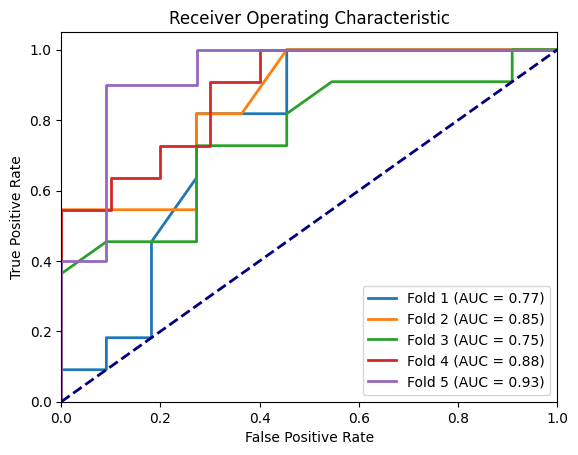

   AUC Train  AUC Test
0   0.981071  0.768595
1   0.923743  0.851240
2   0.949703  0.752066
3   0.921247  0.881818
4   0.958774  0.927273
Validation accuracies for each fold:  [0.7272727272727273, 0.6818181818181818, 0.5454545454545454, 0.7142857142857143, 0.8571428571428571]
Average validation accuracy:  0.7051948051948053
Best validation accuracy:  0.8571428571428571
Best model index:  106


In [91]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Setup Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

# Initialize logistic regression model
# Prepare to collect results
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
validation_accuracies = []

best_accuracy = 0
best_model = None
best_model_idx = -1

# Cross-validation loop
for (train, test), i in zip(cv.split(X, y), range(5)):
    print(train)
    
    augmented_X, augmented_y = augment_data(np.array(X)[train], np.array(y)[train], num_augmented_samples=1)
    augmented_X =  scaler.fit_transform(augmented_X)
    clf.fit(augmented_X, augmented_y)
    
    _, _, auc_score_train = compute_roc_auc(train, clf, X, y)
    fpr, tpr, auc_score = compute_roc_auc(test, clf, X, y)
    
    train_preds = clf.predict(augmented_X)
    test_preds = clf.predict(X[test])
    
    train_accuracy = accuracy_score(augmented_y, train_preds)
    checker =[]
    for i in test:
        checker.append(y[i])
    test_accuracy = accuracy_score(checker, test_preds)
    
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    
    validation_accuracies.append(test_accuracy)
    
    # Save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = clf
        best_model_idx = i
        print(classification_report(checker, test_preds))

# Plot the ROC curves
plot_roc_curve(fprs, tprs)

# Display the scores
print(pd.DataFrame(scores, columns=['AUC Train', 'AUC Test']))

# Print the validation accuracy for each fold and the average validation accuracy
print("Validation accuracies for each fold: ", validation_accuracies)
print("Average validation accuracy: ", np.mean(validation_accuracies))
print("Best validation accuracy: ", best_accuracy)
print("Best model index: ", best_model_idx)




In [14]:
np.std(validation_accuracies)

np.float64(0.09958027392607431)

In [15]:
len(test_preds)

21

In [ ]:
checker

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [ ]:
from sklearn.metrics import classification_report
checker = best_model.predict(X_test)


In [ ]:
train

array([  0,   1,   2,   3,   4,   7,  10,  11,  12,  13,  14,  15,  16,
        18,  19,  20,  21,  23,  25,  26,  27,  28,  29,  30,  32,  33,
        34,  35,  36,  37,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  57,  58,  63,  64,  66,
        67,  68,  70,  71,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        96,  97,  98,  99, 100, 102, 103, 105, 107])

In [ ]:
y_test

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
best_model.predict(X_val) == y_val

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False])

# LR

/home/blastaistudent/miniconda3/envs/ld/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/blastaistudent/miniconda3/envs/ld/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/blastaistudent/miniconda3/envs/ld/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.50      1.00      0.67        11

    accuracy                           0.50        22
   macro avg       0.25      0.50      0.33        22
weighted avg       0.25      0.50      0.33        22



/home/blastaistudent/miniconda3/envs/ld/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/blastaistudent/miniconda3/envs/ld/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/blastaistudent/miniconda3/envs/ld/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/blastaistudent/minic

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.52      1.00      0.69        11

    accuracy                           0.52        21
   macro avg       0.26      0.50      0.34        21
weighted avg       0.27      0.52      0.36        21



/home/blastaistudent/miniconda3/envs/ld/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


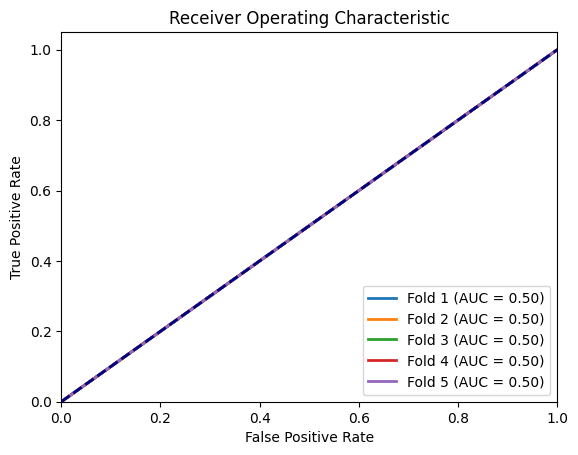

   AUC Train  AUC Test
0        0.5       0.5
1        0.5       0.5
2        0.5       0.5
3        0.5       0.5
4        0.5       0.5
Validation accuracies for each fold:  [0.5, 0.5, 0.5, 0.5238095238095238, 0.47619047619047616]
Average validation accuracy:  0.5
Best validation accuracy:  0.5238095238095238
Best model index:  99


In [133]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold



# Setup Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

# Initialize logistic regression model
clf = LogisticRegression(penalty='l2', C=2.0, max_iter=1000, multi_class='auto', solver='lbfgs')

# Prepare to collect results
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
validation_accuracies = []

best_accuracy = 0
best_model = None
best_model_idx = -1

# Cross-validation loop
for (train, test), i in zip(cv.split(X, y), range(5)):
    augmented_X, augmented_y = augment_data(np.array(X)[train], np.array(y)[train], num_augmented_samples=2)
    augmented_X =  scaler.fit_transform(augmented_X)
    clf.fit(augmented_X, augmented_y)

    
    _, _, auc_score_train = compute_roc_auc(train, clf, X, y)
    fpr, tpr, auc_score = compute_roc_auc(test, clf, X, y)
    
    train_preds = clf.predict(augmented_X)
    test_preds = clf.predict(X[test])
    
    train_accuracy = accuracy_score(augmented_y, train_preds)
    checker =[]
    for i in test:
        checker.append(y[i])
    test_accuracy = accuracy_score(checker, test_preds)
    
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    
    validation_accuracies.append(test_accuracy)


    
    # Save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = clf
        best_model_idx = i
        from sklearn.metrics import classification_report

        print(classification_report(checker, test_preds))

# Plot the ROC curves
plot_roc_curve(fprs, tprs)

# Display the scores
print(pd.DataFrame(scores, columns=['AUC Train', 'AUC Test']))

# Print the validation accuracy for each fold and the average validation accuracy
print("Validation accuracies for each fold: ", validation_accuracies)
print("Average validation accuracy: ", np.mean(validation_accuracies))
print("Best validation accuracy: ", best_accuracy)
print("Best model index: ", best_model_idx)



In [18]:
np.std(validation_accuracies)

np.float64(0.02693044331601001)

In [19]:
best_model.predict(X_val)==valloader.dataset.labels

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False])

# DL (95.4% accuracy)

In [20]:

import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import TensorDataset



In [27]:


# Function to calculate the output size after conv and pool layers
def conv_output_size(input_size, kernel_size, padding, stride):
    return (input_size - kernel_size + 2 * padding) // stride + 1

class Conv1DModel(nn.Module):
    def __init__(self, input_length):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Calculate the size after conv and pool layers
        conv1_output_size = conv_output_size(input_length, 3, 1, 1) // 2
        conv2_output_size = conv_output_size(conv1_output_size, 3, 1, 1) // 2
        conv3_output_size = conv_output_size(conv2_output_size, 3, 1, 1) // 2
        self.fc1 = nn.Linear(64 * conv3_output_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Setup Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Initialize lists to collect results
fprs, tprs, scores = [], [], []
validation_accuracies = []

best_accuracy = 0
best_model = None
best_model_idx = -1 

# Assuming X is the input features and y is the target
input_length = X.shape[1]  # Length of each input sequence

# Cross-validation loop
for (train_idx, test_idx), fold in zip(cv.split(X, y), range(10)):
    # Split data into training and testing sets
    augmented_X,augmented_y= augment_data(np.array(X)[train], np.array(y)[train], num_augmented_samples=2)
    X_test, y_test = np.array(X)[test_idx], np.array(y)[test_idx]
    y_train = augmented_y
    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(augmented_X)
    X_test = scaler.transform(X_test)

    # Convert data to PyTorch tensors and reshape for Conv1D
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize the model, loss function, and optimizer
    model = Conv1DModel(input_length=input_length)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Train the model
    model.train()
    for epoch in range(50):  # Adjust the number of epochs as needed
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train).squeeze().round()
        test_preds = model(X_test).squeeze().round()
    
    train_accuracy = accuracy_score(y_train.numpy(), train_preds.numpy())
    test_accuracy = accuracy_score(y_test.numpy(), test_preds.numpy())
    
    validation_accuracies.append(test_accuracy)
    
    # Save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model_state_dict = model.state_dict()
        best_model = model
        best_model_idx = fold

# Print the validation accuracy for each fold and the average validation accuracy
print("Validation accuracies for each fold: ", validation_accuracies)
print("Average validation accuracy: ", np.mean(validation_accuracies))
print("Best validation accuracy: ", best_accuracy)
print("Best model index: ", best_model_idx)


torch.save(best_model_state_dict, "CNNbest8-8-2024.pth")



Validation accuracies for each fold:  [0.9545454545454546, 0.9545454545454546, 0.9545454545454546, 0.9047619047619048, 0.9047619047619048]
Average validation accuracy:  0.9346320346320347
Best validation accuracy:  0.9545454545454546
Best model index:  0


In [30]:
with torch.no_grad():
    test_preds = best_model(X_test).squeeze().round()
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95        11
         1.0       0.91      1.00      0.95        10

    accuracy                           0.95        21
   macro avg       0.95      0.95      0.95        21
weighted avg       0.96      0.95      0.95        21



In [ ]:
np.std(validation_accuracies)

np.float64(0.06322421529682123)

In [ ]:
test_preds

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import shap

# Function to calculate the output size after conv and pool layers
def conv_output_size(input_size, kernel_size, padding, stride):
    return (input_size - kernel_size + 2 * padding) // stride + 1

class Conv1DModel(nn.Module):
    def __init__(self, input_length):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Calculate the size after conv and pool layers
        conv1_output_size = conv_output_size(input_length, 3, 1, 1) // 2
        conv2_output_size = conv_output_size(conv1_output_size, 3, 1, 1) // 2
        conv3_output_size = conv_output_size(conv2_output_size, 3, 1, 1) // 2
        self.fc1 = nn.Linear(64 * conv3_output_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Setup Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=3, shuffle=True)

# Initialize lists to collect results
fprs, tprs, scores = [], [], []
validation_accuracies = []

best_accuracy = 0
best_model = None
best_model_idx = -1 

# Assuming X is the input features and y is the target
input_length = X.shape[1]  # Length of each input sequence

# Cross-validation loop
for (train_idx, test_idx), fold in zip(cv.split(X, y), range(10)):
    # Split data into training and testing sets
    augmented_X, augmented_y = augment_data(np.array(X)[train], np.array(y)[train], num_augmented_samples=2)
    X_test, y_test = np.array(X)[test_idx], np.array(y)[test_idx]
    y_train = augmented_y
    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(augmented_X)
    X_test = scaler.transform(X_test)

    # Convert data to PyTorch tensors and reshape for Conv1D
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize the model, loss function, and optimizer
    model = Conv1DModel(input_length=input_length)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Train the model
    model.train()
    for epoch in range(50):  # Adjust the number of epochs as needed
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()


    # Evaluate the model
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train_tensor).squeeze().round()
        test_preds = model(X_test_tensor).squeeze().round()

    train_accuracy = accuracy_score(y_train_tensor.numpy(), train_preds.numpy())
    test_accuracy = accuracy_score(y_test_tensor.numpy(), test_preds.numpy())

    validation_accuracies.append(test_accuracy)

    # Save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model_state_dict = model.state_dict()
        best_model = model
        best_model_idx = fold

# Print the validation accuracy for each fold and the average validation accuracy
print("Validation accuracies for each fold: ", validation_accuracies)
print("Average validation accuracy: ", np.mean(validation_accuracies))
print("Best validation accuracy: ", best_accuracy)
print("Best model index: ", best_model_idx)

torch.save(best_model_state_dict, "CNNbest8-8-2024.pth")

Validation accuracies for each fold:  [0.9722222222222222, 0.9722222222222222, 0.9166666666666666]
Average validation accuracy:  0.9537037037037037
Best validation accuracy:  0.9722222222222222
Best model index:  0


              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.90      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



In [ ]:
import shap
def predict_fn(data):
        # Convert data to PyTorch tensor
    data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension for Conv1D
        # Make predictions
    model.eval()
    with torch.no_grad():
        logits = model(data_tensor)
    return logits.squeeze().cpu().numpy().reshape(-1)  # Ensure output is 1-dimensional

    # Convert X_train to NumPy array for SHAP
X_train_np = X_train.astype(np.float32)

explainer = shap.KernelExplainer(predict_fn, X_train_np[20:42])
shap_values = explainer.shap_values(X_train_np[20:42])
shap.summary_plot(shap_values, X_train_np[20:42])

Plotting histograms for the best model's parameters...


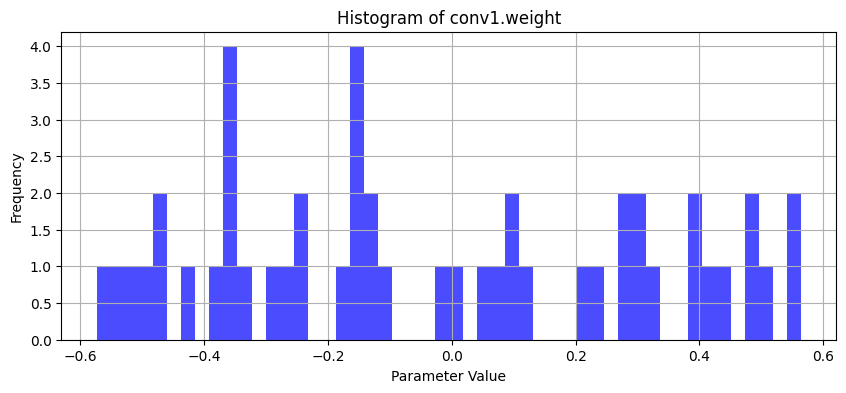

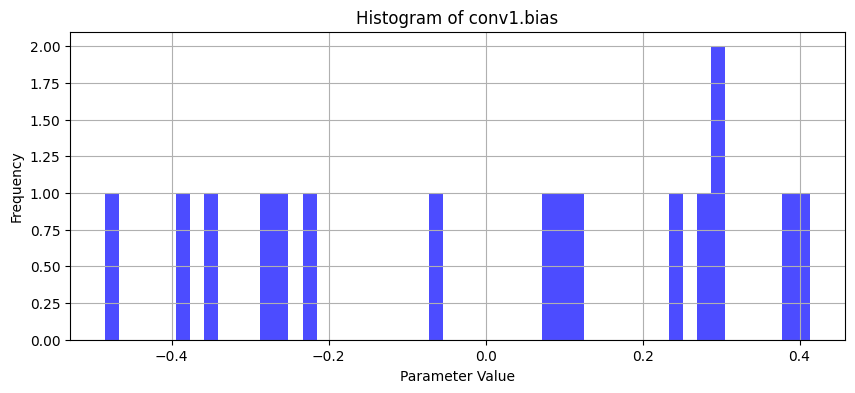

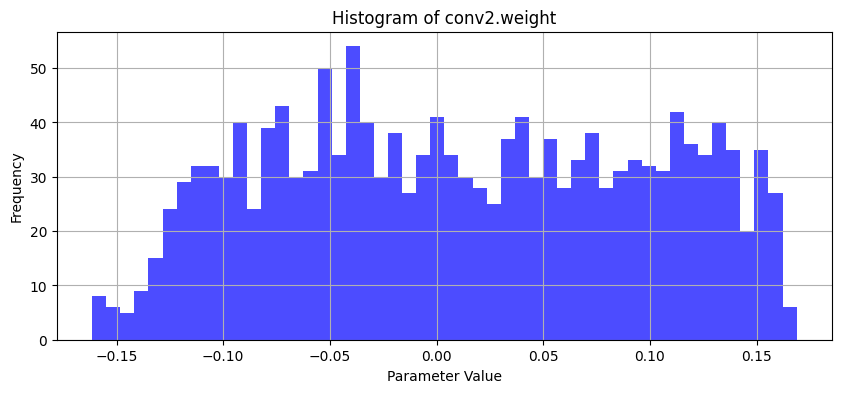

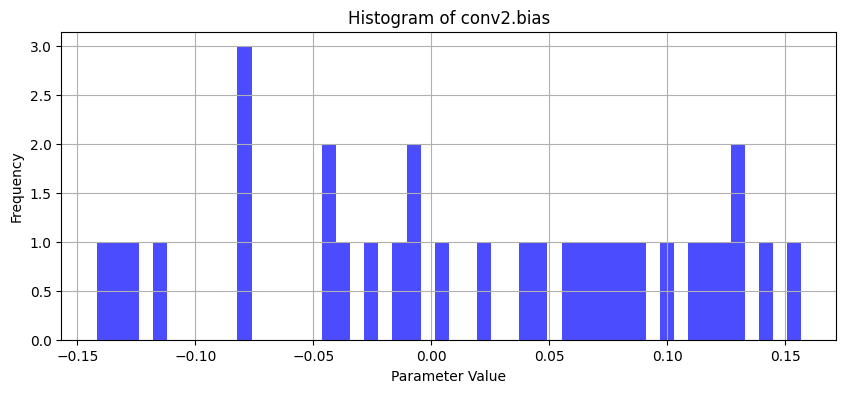

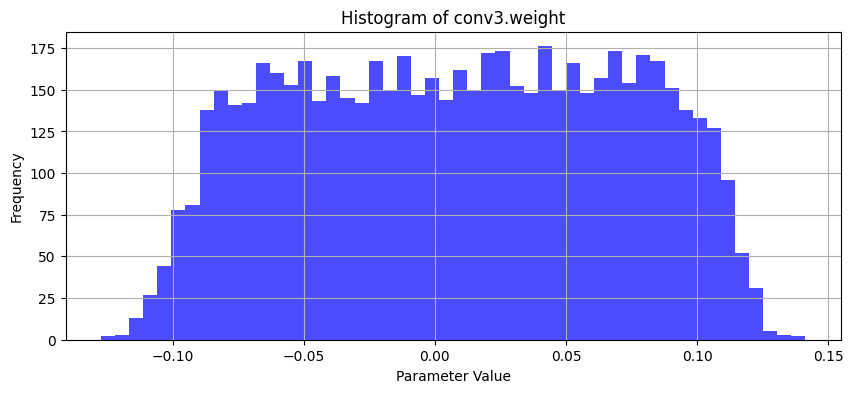

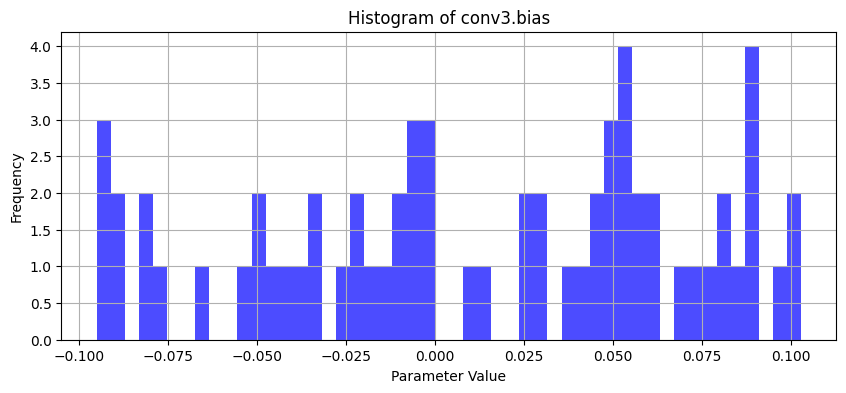

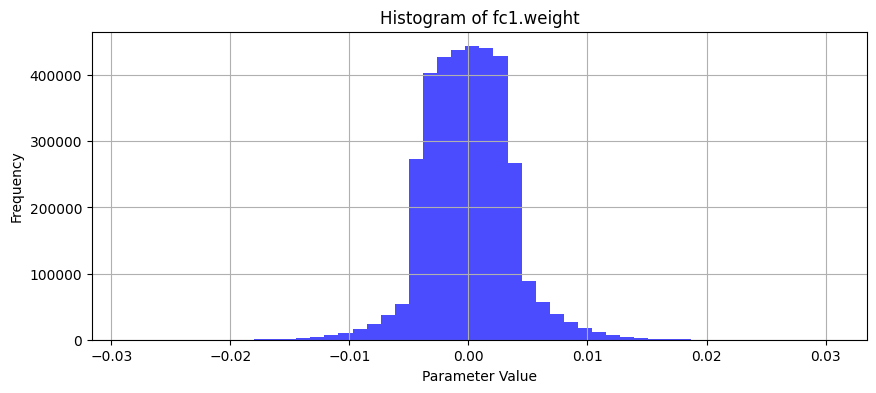

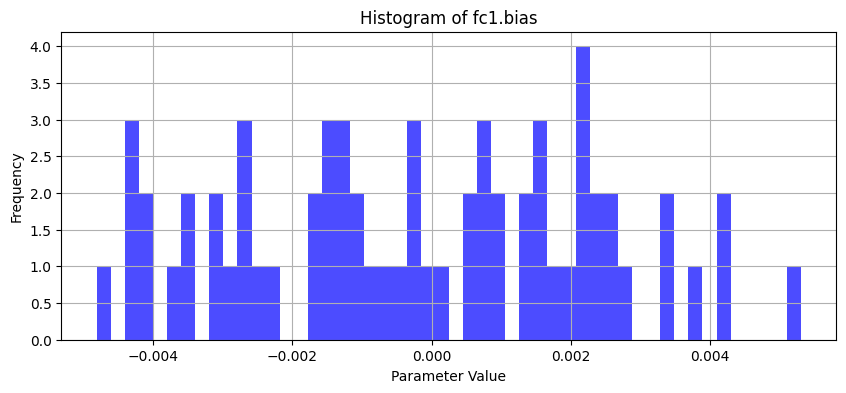

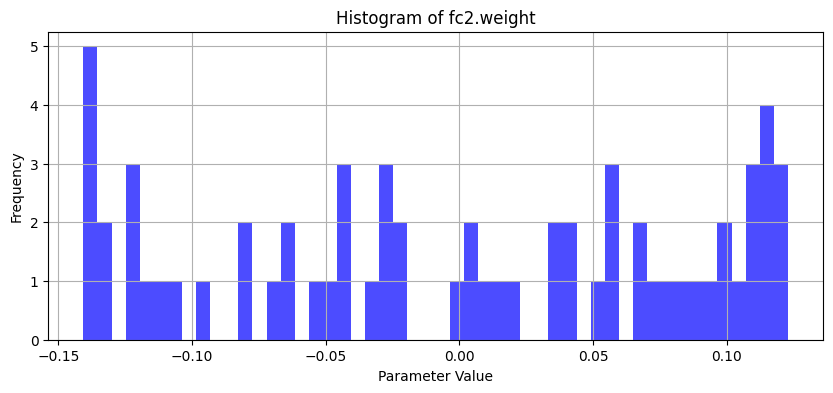

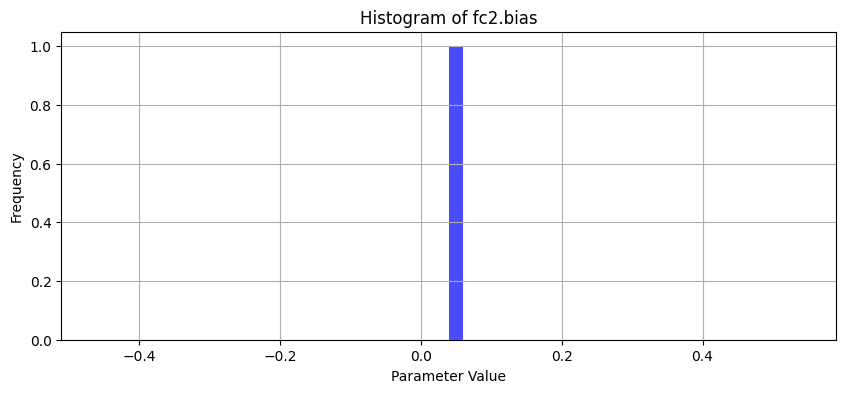

In [ ]:
import matplotlib.pyplot as plt

# Function to plot histograms of model parameters
def plot_param_histograms(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            plt.figure(figsize=(10, 4))
            plt.hist(param.data.cpu().numpy().flatten(), bins=50, color='blue', alpha=0.7)
            plt.title(f'Histogram of {name}')
            plt.xlabel('Parameter Value')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

# After training the best model, visualize its parameters
if best_model is not None:
    print("Plotting histograms for the best model's parameters...")
    plot_param_histograms(best_model)


  0%|          | 0/22 [00:00<?, ?it/s]

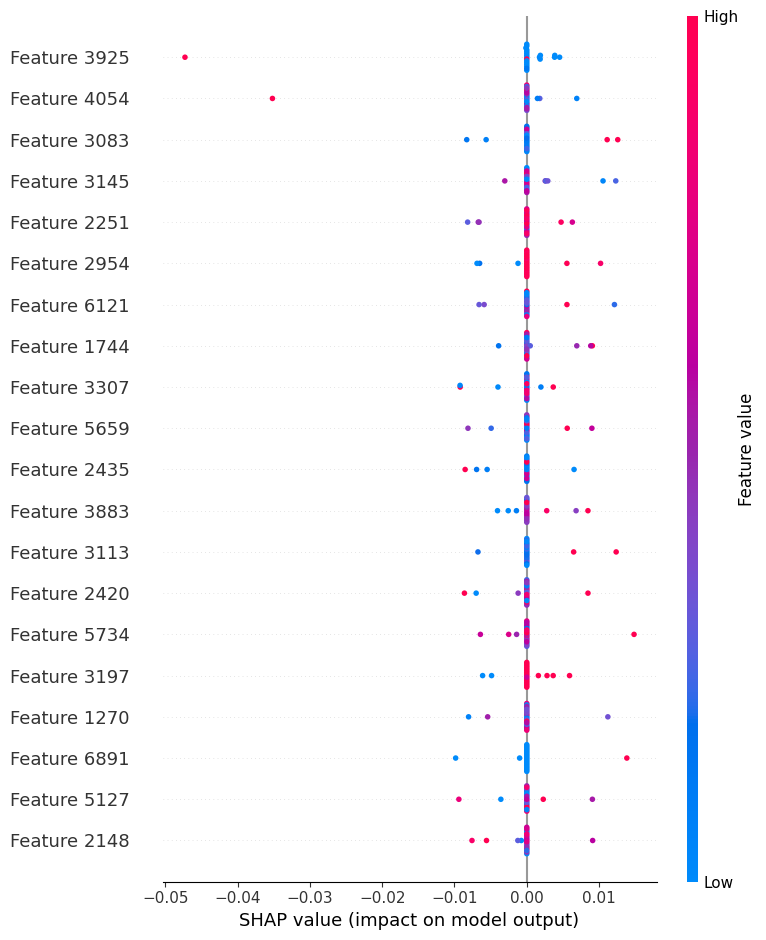

In [ ]:
explainer = shap.KernelExplainer(predict_fn, X_train_np[20:42])
shap_values = explainer.shap_values(X_train_np[20:42])
shap.summary_plot(shap_values, X_train_np[20:42])

In [ ]:
np.std(validation_accuracies)


np.float64(0.04082482904638629)

In [ ]:
old = [0.86363636, 0.95454545, 0.863636,0.809523,0.90476]
np.std(old)


np.float64(0.04831065662609211)

In [ ]:
len(X_test)/len(X_train)

0.20833333333333334

In [ ]:
y_test_tensor

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.])

In [ ]:
len(X_test_tensor)

36

In [ ]:
import lime
import lime.lime_tabular


X_test_flat = X_test_tensor.numpy().reshape(X_test_tensor.shape[0], -1)

# Create a prediction function that returns probabilities
def predict_fn(X):
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Reshape to match the input format of the Conv1D model
    model.eval()
    with torch.no_grad():
        probs = model(X_tensor).squeeze().numpy()
    return np.column_stack([1 - probs, probs])  # Return probabilities for both classes

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_test_flat,
    mode='classification',
    training_labels=y_test,
    feature_names=[f"feature_{i}" for i in range(X_test_flat.shape[1])],
    class_names=['Negative', 'Positive'],
    discretize_continuous=True
)

# Choose an instance from the test set to explain
instance_idx = 35
exp = explainer.explain_instance(X_test_flat[instance_idx], predict_fn, num_features=10)

# Display the explanation
exp.show_in_notebook(show_table=True)


In [ ]:


# Function to calculate the output size after conv and pool layers
def conv_output_size(input_size, kernel_size, padding, stride):
    return (input_size - kernel_size + 2 * padding) // stride + 1

class Conv1DModel(nn.Module):
    def __init__(self, input_length):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Calculate the size after conv and pool layers
        conv1_output_size = conv_output_size(input_length, 3, 1, 1) // 2
        conv2_output_size = conv_output_size(conv1_output_size, 3, 1, 1) // 2
        conv3_output_size = conv_output_size(conv2_output_size, 3, 1, 1) // 2
        self.fc1 = nn.Linear(64 * conv3_output_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Setup Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=3, shuffle=True)

# Initialize lists to collect results
fprs, tprs, scores = [], [], []
validation_accuracies = []

best_accuracy = 0
best_model = None
best_model_idx = -1 

# Assuming X is the input features and y is the target
input_length = X.shape[1]  # Length of each input sequence

# Cross-validation loop
for (train_idx, test_idx), fold in zip(cv.split(X, y), range(10)):
    # Split data into training and testing sets
    augmented_X,augmented_y= augment_data(np.array(X)[train_idx], np.array(y)[train_idx], num_augmented_samples=2)
    X_test, y_test = np.array(X)[test_idx], np.array(y)[test_idx]
    y_train = augmented_y
    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(augmented_X)
    X_test = scaler.transform(X_test)

    # Convert data to PyTorch tensors and reshape for Conv1D
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize the model, loss function, and optimizer
    model = Conv1DModel(input_length=input_length)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Train the model
    model.train()
    for epoch in range(50):  # Adjust the number of epochs as needed
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train).squeeze().round()
        test_preds = model(X_test).squeeze().round()
    
    train_accuracy = accuracy_score(y_train.numpy(), train_preds.numpy())
    test_accuracy = accuracy_score(y_test.numpy(), test_preds.numpy())
    
    validation_accuracies.append(test_accuracy)
    
    # Save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model_state_dict = model.state_dict()
        best_model = model
        best_model_idx = fold

# Print the validation accuracy for each fold and the average validation accuracy
print("Validation accuracies for each fold: ", validation_accuracies)
print("Average validation accuracy: ", np.mean(validation_accuracies))
print("Best validation accuracy: ", best_accuracy)
print("Best model index: ", best_model_idx)

torch.save(best_model_state_dict, "CNNbest8-8-2024.pth")



Validation accuracies for each fold:  [0.5833333333333334, 0.625, 0.6666666666666666, 0.625, 0.5833333333333334]
Average validation accuracy:  0.6166666666666667
Best validation accuracy:  0.6666666666666666
Best model index:  2


In [ ]:
X_val =[]
y_val = valloader.dataset.labels


for i in range(len(valloader.dataset)):
    X_val.append(valloader.dataset[i][0][0])

print("Features shape:", X_val)
print("Labels shape:", y_val)
X_val = np.array(X_val)


Features shape: [tensor([0.9334, 0.9580, 0.5324,  ..., 1.0000, 1.0000, 0.0000]), tensor([0.9922, 0.6797, 0.0246,  ..., 1.0000, 1.0000, 0.0000]), tensor([0.6261, 0.8040, 0.5378,  ..., 0.0000, 0.0000, 0.0000]), tensor([1.6840, 0.5448, 0.6566,  ..., 1.0000, 1.0000, 0.0000]), tensor([1.1306, 0.0107, 0.0000,  ..., 0.0000, 1.0000, 0.0000]), tensor([3.6417, 0.6650, 0.0000,  ..., 1.0000, 1.0000, 0.0000]), tensor([1.3384, 0.6053, 0.5947,  ..., 0.0000, 0.0000, 0.0000]), tensor([0.5014, 0.8462, 0.0961,  ..., 0.0000, 0.0000, 0.0000]), tensor([2.0041, 0.0464, 0.0000,  ..., 0.0000, 0.0000, 0.0000]), tensor([0.4934, 0.7404, 0.3937,  ..., 0.0000, 0.0000, 0.0000]), tensor([1.1203, 0.2788, 0.0000,  ..., 0.0000, 0.0000, 0.0000]), tensor([0.4637, 0.0134, 0.7493,  ..., 1.0000, 1.0000, 0.0000])]
Labels shape: [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]


In [ ]:
# Assuming 'data_loader' is your DataLoader object

y = dataloader.dataset.labels
# Iterate through the DataLoader to extract features and labels
# Concatenate all the features and labels into single tensors

print("Features shape:", X)
print("Labels shape:", y)

Features shape: [tensor([2.5671, 0.3718, 0.0000,  ..., 0.0000, 0.0000, 0.0000]), tensor([0.8043, 0.1046, 0.6522,  ..., 1.0000, 1.0000, 0.0000]), tensor([0.6784, 0.0706, 0.0083,  ..., 0.0000, 0.0000, 0.0000]), tensor([0.9765, 0.3418, 0.3026,  ..., 1.0000, 1.0000, 0.0000]), tensor([0.1562, 0.8453, 0.3731,  ..., 0.0000, 0.0000, 0.0000]), tensor([1.0348, 0.1223, 0.2029,  ..., 1.0000, 1.0000, 0.0000]), tensor([0.9095, 0.2808, 0.9437,  ..., 0.0000, 0.0000, 0.0000]), tensor([1.1525, 0.2213, 0.8617,  ..., 1.0000, 1.0000, 0.0000]), tensor([2.2861, 0.7956, 0.3503,  ..., 1.0000, 1.0000, 0.0000]), tensor([1.3397, 0.3178, 0.2346,  ..., 1.0000, 1.0000, 0.0000]), tensor([0.5668, 0.2763, 0.0000,  ..., 0.0000, 0.0000, 0.0000]), tensor([2.3730, 0.7413, 0.0443,  ..., 1.0000, 1.0000, 0.0000]), tensor([0.8675, 0.1452, 0.7814,  ..., 1.0000, 1.0000, 0.0000]), tensor([1.6597, 0.4028, 0.1373,  ..., 1.0000, 1.0000, 0.0000]), tensor([0.9847, 0.6072, 0.2263,  ..., 1.0000, 0.0000, 0.0000]), tensor([1.6944, 0.5476,

In [ ]:
best_model = Conv1DModel(input_length=input_length)
best_model.load_state_dict(torch.load("CNNbest8-8-2024.pth"))
X_val = scaler.transform(X_val)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
predictions= []


# Use the best model to make predictions
best_model.eval()
with torch.no_grad():
    predictions = best_model(X_val).squeeze().round()
    # Process predictions as needed

/tmp/ipykernel_4168503/897658290.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("CNNbest8-8-2024.pth"))


In [ ]:
predictions

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:


# Function to calculate the output size after conv and pool layers
def conv_output_size(input_size, kernel_size, padding, stride):
    return (input_size - kernel_size + 2 * padding) // stride + 1

class Conv1DModel(nn.Module):
    def __init__(self, input_length):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.dropout1 = nn.Dropout(0.3)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.4)
        
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.4)

        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.4)

        # Calculate the size after conv and pool layers
        conv1_output_size = conv_output_size(input_length, 3, 1, 1) // 2
        conv2_output_size = conv_output_size(conv1_output_size, 3, 1, 1) // 2
        conv3_output_size = conv_output_size(conv2_output_size, 3, 1, 1) // 2
        conv4_output_size = conv_output_size(conv3_output_size, 3, 1, 1) // 2
        self.fc1 = nn.Linear(256 * conv4_output_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.dropout_fc = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        self.elu = nn.ELU()
        self.selu = nn.SELU()

    def forward(self, x):
        x = self.pool(F.tanh(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(F.tanh(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(F.tanh(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        x = self.pool(F.tanh(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.dropout_fc(F.selu(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x

# Setup Stratified K-Folds cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to collect results
validation_accuracies = []

best_accuracy = 0
best_model = None
best_model_idx = -1 

# Assuming X is the input features and y is the target
input_length = X.shape[1]  # Length of each input sequence

# Cross-validation loop
for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    # Split data into training and testing sets
    augmented_X, augmented_y = augment_data(np.array(X)[train], np.array(y)[train], num_augmented_samples=2)
    X_test, y_test = np.array(X)[test_idx], np.array(y)[test_idx]
    
    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(augmented_X)
    X_test = scaler.transform(X_test)

    # Convert data to PyTorch tensors and reshape for Conv1D
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(augmented_y, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize the model, loss function, and optimizer
    model = Conv1DModel(input_length=input_length)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Train the model
    model.train()
    for epoch in range(20):  # Adjust the number of epochs as needed
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train).squeeze().round()
        test_preds = model(X_test).squeeze().round()
    
    train_accuracy = accuracy_score(y_train.numpy(), train_preds.numpy())
    test_accuracy = accuracy_score(y_test.numpy(), test_preds.numpy())
    print(test_accuracy)
    validation_accuracies.append(test_accuracy)
    
    # Save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model_state_dict = model.state_dict()
        best_model = model
        best_model_idx = fold

# Print the validation accuracy for each fold and the average validation accuracy
print("Validation accuracies for each fold: ", validation_accuracies)
print("Average validation accuracy: ", np.mean(validation_accuracies))
print("Best validation accuracy: ", best_accuracy)
print("Best model index: ", best_model_idx)

torch.save(best_model_state_dict, "CNNbest8-8-2024.pth")


0.7083333333333334
0.5833333333333334
0.6666666666666666
0.5
0.8333333333333334
Validation accuracies for each fold:  [0.7083333333333334, 0.5833333333333334, 0.6666666666666666, 0.5, 0.8333333333333334]
Average validation accuracy:  0.6583333333333334
Best validation accuracy:  0.8333333333333334
Best model index:  4


In [ ]:
y_test

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 1.])

In [ ]:
test_preds

tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 1.])